# Cleanup RELAMAGO Data

## Imports

In [496]:
import sys
sys.path.append('src/')

import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as ticker

from dealias import VelocityDealiaser
from feature_extraction import create_downsampler, create_upsampler
from plotting import create_polar_plot, add_cbar
import pyart

## Read in the radar

In [497]:
import glob

In [779]:
files = sorted(glob.glob('/Users/mgrover/git_repos/ot-dda-analysis/data/raw-radar-data/20181110-IOP04/DOW6/radar/cfradial/low/*el0.??_SUR.nc'))

In [787]:
radar = pyart.io.read(files[7])

## Plot the Initial Reflectivity and Velocity Fields

(-20.0, 20.0)

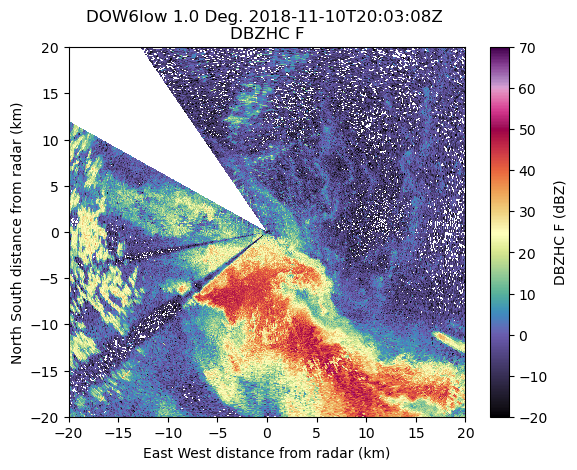

In [789]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('DBZHCC_F',
                 cmap='pyart_ChaseSpectral',
                 vmin=-20, vmax=70)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

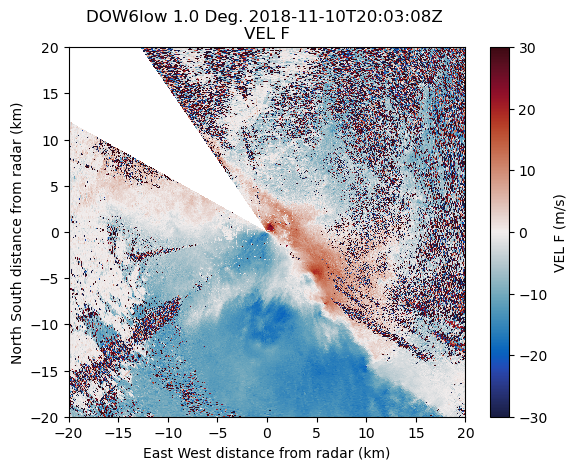

In [790]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('VEL_F',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 vmax=30)
plt.xlim(-20, 20)
plt.ylim(-20, 20);

## Clean the Data Using the Velocity Texture

In [813]:
nyq = np.array(radar.get_nyquist_vel(0))

vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3, nyq=nyq
)
radar.add_field("velocity_texture", vel_texture, replace_existing=True)

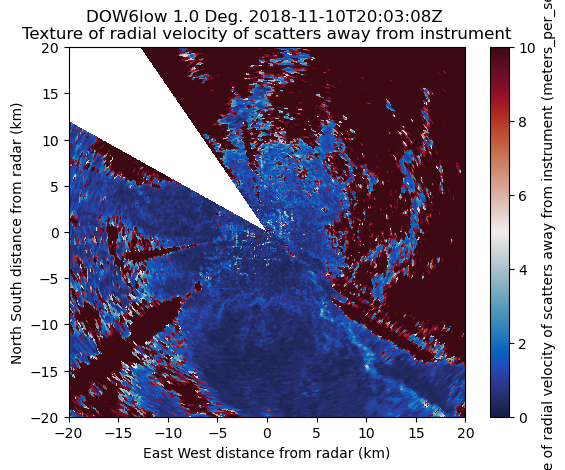

In [814]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('velocity_texture',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=0,
                 vmax=10)
plt.xlim(-20, 20)
plt.ylim(-20, 20);

Text(0, 0.5, 'Count')

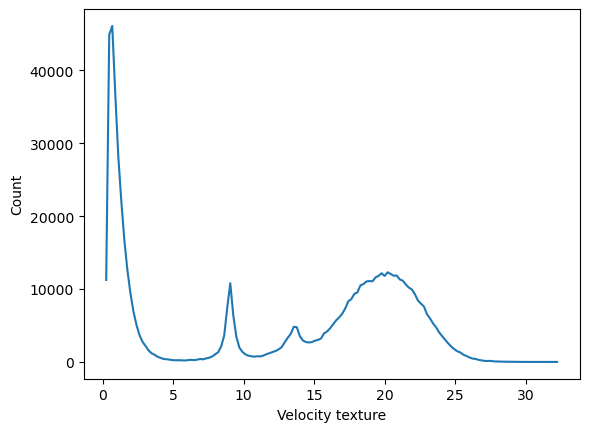

In [815]:
hist, bins = np.histogram(radar.fields["velocity_texture"]["data"], bins=150)
bins = (bins[1:] + bins[:-1]) / 2.0
plt.plot(bins, hist)
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [816]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above("velocity_texture", 10)

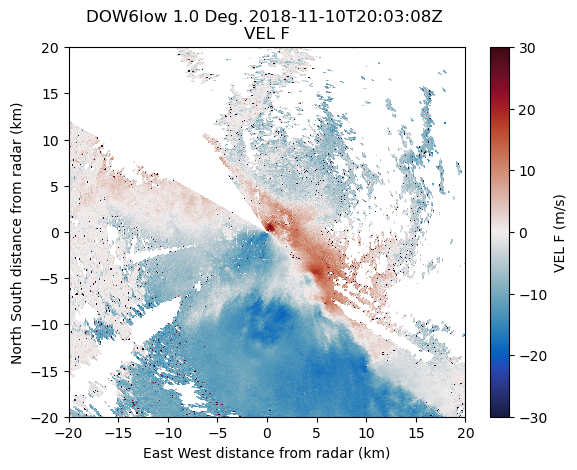

In [817]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('VEL_F',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 gatefilter=gatefilter,
                 vmax=30)
plt.xlim(-20, 20)
plt.ylim(-20, 20);

In [818]:
vel_array = np.ma.masked_where(
    gatefilter.gate_included == False, radar.fields["VEL_F"]["data"]
)
radar.add_field_like("VEL_F", "corrected_velocity", vel_array, replace_existing=True)

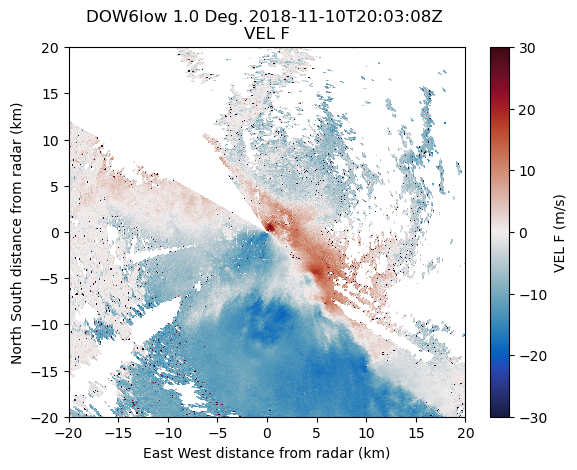

In [819]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 gatefilter=gatefilter,
                 vmax=30)
plt.xlim(-20, 20)
plt.ylim(-20, 20);

## Run the Unet Dealiasing Algorithm

In [820]:
start_neurons_az=16 # sn=16
vel=tf.keras.Input(shape=(None,None,1))
        
# Down portion of unet
down=create_downsampler(inp=vel,
                             start_neurons=start_neurons_az,
                             input_channels=1)
# Up portion of unet        
up=create_upsampler(n_inputs=1,
                           start_neurons=start_neurons_az,
                           n_outputs=6)

# Full model
vda = VelocityDealiaser(down,up)

# Load weights
vda.load_weights('models/dealias_sn16_csi9669.SavedModel')

2023-01-26 14:57:21.191573: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/dealias_sn16_csi9669.SavedModel: FAILED_PRECONDITION: models/dealias_sn16_csi9669.SavedModel; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [821]:
start_neurons_az=16
vel=tf.keras.Input(shape=(None,None,1))
        
# Down portion of unet
down=create_downsampler(inp=vel,
                             start_neurons=start_neurons_az,
                             input_channels=1)
# Up portion of unet        
up=create_upsampler(n_inputs=1,
                           start_neurons=start_neurons_az,
                           n_outputs=6)

# Full model
vda = VelocityDealiaser(down,up)

# Load weights
vda.load_weights('models/dealias_sn16_csi9669.SavedModel')

2023-01-26 14:57:22.912207: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/dealias_sn16_csi9669.SavedModel: FAILED_PRECONDITION: models/dealias_sn16_csi9669.SavedModel; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


## Preprocess the radar data for the algorithm
We need the range to be divisible by 64, so we clip our data, and reshape our arrays

In [811]:
# Use the masked radial velocity data
vrad = radar.fields['corrected_velocity']['data']

# Determine the number of range gates to extract, divisible by 64
clip = vrad.shape[1] % 64

# Clip the radial velocity array accordingly
vrad = vrad[:, :-clip]

# Reshape the radial velocity for the algorithm
vrad = np.expand_dims(np.expand_dims(vrad, -1), 0)

# Do the same for the nyquist velocity

nyq = np.expand_dims(nyq, 0)

In [802]:
# Preprocess data
l2=vrad.copy()     # [n_frames, Naz, Nrng, 1]
#l3=data['l3']
nyq=nyq

n_frames = 1 
assert l2.shape[0]==n_frames # alg only takes in 1 time frame

##  Prep data for UNet
# Add batch dim
l2=l2[None,...]
nyq=nyq[None,...]

# Split 0.5 degree data into two 1 degree arrays 
if l2.shape[2]==720:
    s=l2.shape
    l2 = np.reshape(l2,(s[0],s[1],s[2]//2,2,s[3],s[4]))
    l2 = np.transpose(l2,(0,3,1,2,4,5))
    l2 = np.reshape(l2, (2*s[0],s[1],s[2]//2,s[3],s[4]))
    nyq=np.stack((nyq,nyq))
    nyq=np.transpose(nyq,(1,0,2))
    nyq=np.reshape(nyq,(-1,n_frames,1))
    recombine=True
else:
    recombine=False
    
# Pad data 12 degrees on either side with periodic boundary conditions
pad_deg=12
l2 = np.concatenate( (l2[:,:,-pad_deg:,:,:],
                                l2,
                                l2[:,:,:pad_deg,:,:]),axis=2)  

# Replace bad values with NAN
l2[l2<=-64]=np.nan

print('vel input (batch, n_frames, Naz, Nrng, 1) =',l2.shape)   
print('nyq input (batch, n_frames, 1) =',nyq.shape)  

vel input (batch, n_frames, Naz, Nrng, 1) = (2, 1, 384, 960, 1)
nyq input (batch, n_frames, 1) = (2, 1, 1)


In [803]:
# Run UNet
inp = {'vel':l2,'nyq':nyq}
out=vda.predict(inp)
dealiased_vel=out['dealiased_vel'].copy()

## Post process
# Recombine to 0.5 degree 
if recombine:
    s=dealiased_vel.shape
    dealiased_vel = np.reshape(dealiased_vel,(s[0]//2,2,s[1],s[2],s[3]))
    dealiased_vel = np.transpose(dealiased_vel,(0,2,1,3,4))
    dealiased_vel = np.reshape(dealiased_vel,(s[0]//2,-1,s[2],s[3]))
    dealiased_vel= dealiased_vel[:, :-(pad_deg * 2) * 2, :, :]

output_radar_field = np.empty_like(radar.fields['corrected_velocity']['data']) * np.nan
# Fix bad vals
cleaned_data = cleaned_data = np.where(cleaned_data.squeeze() <= -64, np.nan, cleaned_data.squeeze())
output_radar_field[:, :cleaned_data.shape[1]] = cleaned_data
radar.add_field_like('VEL_F', 'velocity_unet', output_radar_field, replace_existing=True)

1/1 [==============================] - 1s 579ms/step


In [804]:
radar.fields['velocity_unet']['data'].mask = radar.fields['corrected_velocity']['data'].mask

## Plot the Comparisons
Plot the comparisons between the original velocity field and the corrected fields

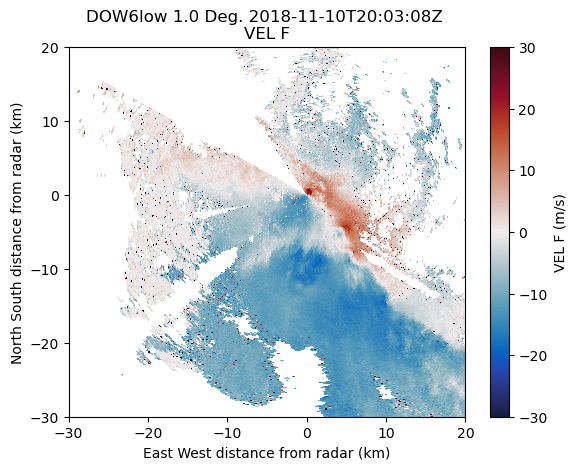

In [822]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 vmax=30)
plt.xlim(-30, 20)
plt.ylim(-30, 20);

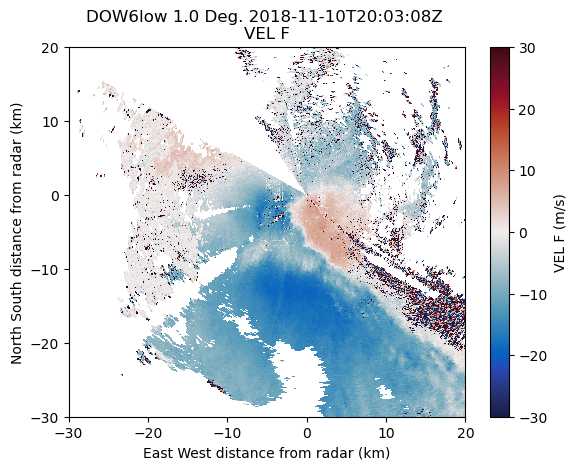

In [823]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('velocity_unet',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 vmax=30)
plt.xlim(-30, 20)
plt.ylim(-30, 20);